In [1]:
#clean up in v02 and run tests

import pandas as pd
import os
from tqdm import tqdm
import time
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, regularizers
from helper_functions.testing_functions import accuracy_distance, accuracy_moneyline, accuracy_ou
from helper_functions.simulate_game import simulate_game
from helper_functions.combine_matrices import combine_team_matrix
from tensorflow.keras.losses import Loss
import seaborn as sns

In [2]:
def pull_game_data(g):
        game_res = pd.read_excel('raw_game_pulls/{}'.format(g))
        game_strings = g.split(' vs ')
        team_A = game_strings[0].split('for ')[-1]
        team_B = game_strings[1].split('.xlsx')[0]

        matrix1 = pd.read_excel('team_specific_matrix/{}_A.xlsx'.format(team_A), index_col='Starting_State')
        matrix2 = pd.read_excel('team_specific_matrix/{}_B.xlsx'.format(team_B), index_col='Starting_State')

        A_score = game_res.iloc[-1]['Home']
        B_score = game_res.iloc[-1]['Away']
        score = (A_score,B_score)

        return matrix1, matrix2, score

In [3]:
#load game data
ma_list = []
mb_list = []
output_list = []

for game in tqdm(os.listdir('raw_game_pulls')):
    a,b,c = pull_game_data(game)
    ma_list.append(a)
    mb_list.append(b)
    output_list.append(c)

  0%|          | 0/5237 [00:00<?, ?it/s]

100%|██████████| 5237/5237 [04:41<00:00, 18.58it/s]


In [4]:
#transform regular output data into argmax array form
arr_outputs = []
for x in output_list:
    value1, value2 = x

    # Create numpy arrays
    array1 = np.zeros(201)
    array2 = np.zeros(201)

    # Set the corresponding indices to 1
    array1[value1 - 1] = 1
    array2[value2 - 1] = 1 
    arr_outputs.append((array1, array2))

In [5]:
#normalize inputs ###############################################################################
all_inputs=ma_list+mb_list

arr = np.array([df.values for df in all_inputs])

# Calculate mean and standard deviation across the first axis (which represents different DataFrames)
avg = np.mean(arr, axis=0)
std_dev = np.std(arr, axis=0)

# Create DataFrames from the calculated arrays
avg_df = pd.DataFrame(avg, index=all_inputs[0].index, columns=all_inputs[0].columns)
std_dev_df = pd.DataFrame(std_dev, index=all_inputs[0].index, columns=all_inputs[0].columns)

norm_inputs_a = []
norm_inputs_b = []

#Normalize each value in each matrix
for matrix in ma_list:
    normalized_matrix = (matrix - avg_df) / std_dev_df
    normalized_matrix=normalized_matrix.fillna(0.)
    norm_inputs_a.append(normalized_matrix)

for matrix in mb_list:
    normalized_matrix = (matrix - avg_df) / std_dev_df
    normalized_matrix=normalized_matrix.fillna(0.)
    norm_inputs_b.append(normalized_matrix)

In [6]:
#split on index for now, later will match with simulations
matrix_A_train = norm_inputs_a[:4000]
matrix_B_train = norm_inputs_b[:4000]

y_train = arr_outputs[:4000]

matrix_A_test = norm_inputs_a[4000:]
matrix_B_test = norm_inputs_b[4000:]

y_test=arr_outputs[4000:]

In [7]:
#do same as above for regular simulation testing
simulation_a_test = ma_list[4000:]
simulation_b_test = mb_list[4000:]

simulation_output_test = output_list[4000:]

In [8]:
#not working right now
# Define custom loss function
class Distance(Loss):
    def call(self, y_true, y_pred):
        # Reshape the input tensors if necessary
        y_true_reshaped = tf.reshape(y_true, (-1, 201))  # Assuming 101 is the number of classes
        y_pred_reshaped = tf.reshape(y_pred, (-1, 201))

        # Compute the argmax operation with the correct axis
        a_pred = tf.argmax(y_pred_reshaped[0], axis=1)
        b_pred = tf.argmax(y_pred_reshaped[1], axis=1)

        # Compute the argmax operation for the true labels as well
        a_true = tf.argmax(y_true_reshaped[0], axis=1)
        b_true = tf.argmax(y_true_reshaped[1], axis=1)

        # Compute the loss based on the difference between predicted and true values

        global loss
        global egg
        # egg = tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
        loss = tf.sqrt(tf.cast(tf.square(a_true - a_pred), dtype=tf.float32) + tf.cast(tf.square(b_true - b_pred), dtype=tf.float32))
        # return egg

        return loss

In [9]:
# #attempting to train with customized loss function
# def custom_loss(y_true, y_pred,):
#     # Reshape the input tensors if necessary
#     y_true_reshaped = tf.reshape(y_true, (-1, 201))  # Assuming 101 is the number of classes
#     y_pred_reshaped = tf.reshape(y_pred, (-1, 201))

#     # Compute the argmax operation with the correct axis
#     a_pred = tf.argmax(y_pred_reshaped[0], axis=1)
#     b_pred = tf.argmax(y_pred_reshaped[1], axis=1)

#     # Compute the argmax operation for the true labels as well
#     a_true = tf.argmax(y_true_reshaped[0], axis=1)
#     b_true = tf.argmax(y_true_reshaped[1], axis=1)

#     # Compute the loss based on the difference between predicted and true values
#     loss = tf.sqrt(tf.cast(tf.square(a_true - a_pred), dtype=tf.float32) + tf.cast(tf.square(b_true - b_pred), dtype=tf.float32))
#     return loss

In [10]:
# Define the neural network architecture
def build_model():
    input1 = layers.Input(shape=(18, 18))
    input2 = layers.Input(shape=(18, 18))

    flatten1 = layers.Flatten()(input1)
    flatten2 = layers.Flatten()(input2)

    concat = layers.Concatenate()([flatten1, flatten2])
    dense1 = layers.Dense(200, activation='relu')(concat)
    dense2 = layers.Dense(100, activation='relu')(dense1)

    output1 = layers.Dense(201, activation='softmax', name='output1')(dense2)  # Adjust output dimension to match the range (150 - 50 + 1)
    output2 = layers.Dense(201, activation='softmax', name='output2')(dense2)  # Adjust output dimension to match the range (150 - 50 + 1)

    model = Model(inputs=[input1, input2], outputs=[output1, output2])
    return model

# Define your training function
def train_model(matrixA_list, matrixB_list, output_tuple_list, epochs=10, batch_size=32):
    # Convert DataFrame to numpy arrays
    matrixA_array = np.array(matrixA_list)
    matrixB_array = np.array(matrixB_list)
    output_array = np.array(output_tuple_list)
    
    # Build the model
    model = build_model()

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit([matrixA_array, matrixB_array], [output_array[:, 0], output_array[:, 1]], epochs=epochs, batch_size=batch_size)
    return model

In [11]:
m1 = train_model(matrix_A_train, matrix_B_train, y_train, 10, 64)

Epoch 1/10
63/63 [==============================] - 1s 3ms/step - loss: 9.0355 - output1_loss: 4.5444 - output2_loss: 4.4911 - output1_accuracy: 0.0298 - output2_accuracy: 0.0298  
Epoch 2/10
63/63 [==============================] - 0s 3ms/step - loss: 7.7002 - output1_loss: 3.9038 - output2_loss: 3.7964 - output1_accuracy: 0.0648 - output2_accuracy: 0.0660
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: 7.2896 - output1_loss: 3.6896 - output2_loss: 3.6000 - output1_accuracy: 0.1013 - output2_accuracy: 0.1168
Epoch 4/10
63/63 [==============================] - 0s 3ms/step - loss: 6.9279 - output1_loss: 3.4977 - output2_loss: 3.4303 - output1_accuracy: 0.1400 - output2_accuracy: 0.1482
Epoch 5/10
63/63 [==============================] - 0s 3ms/step - loss: 6.5678 - output1_loss: 3.3006 - output2_loss: 3.2672 - output1_accuracy: 0.1723 - output2_accuracy: 0.1805
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 6.2262 - output1_loss: 3.1287 -

In [44]:
predicted_scores = []
all_predictions_list = []
for i in tqdm(range(len(matrix_A_test))):
    # Convert test matrices to numpy arrays
    test_matrix_a_array = matrix_A_test[i].values.reshape(-1, 18, 18)
    test_matrix_b_array = matrix_B_test[i].values.reshape(-1, 18, 18)

    # Make predictions using the model
    predictions = m1.predict([test_matrix_a_array, test_matrix_b_array], verbose=0)
    all_predictions_list.append(predictions)

    predicted_score = (np.argmax(predictions[0]), np.argmax(predictions[1]))

    predicted_scores.append(predicted_score)

100%|██████████| 1237/1237 [00:45<00:00, 27.18it/s]


In [13]:
#design test for outputs - we have ~1200 test games
#one approach - run simulation 10-100 times for each, find overall accuracy, test against argmax values
#one approach - run simulation 10 times for each, run random weighted choice 10 times for each, compare

In [14]:
all_results=pd.DataFrame()

In [26]:
#ffirst test regular simuation
for g in tqdm(range(len(simulation_a_test))):

    #locate teams to find matrices
    game_res = simulation_output_test[g]

    matrix1 = simulation_a_test[g]
    matrix2 = simulation_b_test[g]

    combined_matrix = combine_team_matrix(matrix1, matrix2)
    # combined_matrix.columns=matrix1.columns

        
    for r in combined_matrix.index:
        if combined_matrix.loc[r].sum()==0.:
            combined_matrix.loc[r]=avg_matrix.loc[r].copy()
            
    combined_matrix = combined_matrix.div(combined_matrix.sum(axis=1), axis=0)

    # Evaluate performance on X game simulations
    result = simulate_game(combined_matrix, 1)
    home_scores = [x[0] for x in result[1]]
    away_scores = [x[1] for x in result[1]]

    current_df = pd.DataFrame(zip(home_scores, away_scores), columns = ['Home','Away'])
    current_df['Game']=g

    all_results=pd.concat([all_results, current_df])

  0%|          | 0/1237 [00:00<?, ?it/s]

100%|██████████| 1237/1237 [01:42<00:00, 12.11it/s]


In [30]:
all_results_copy = all_results.tail(1237).copy().reset_index(drop=True)

In [38]:
#forgot to include actual results - re running that part
real_results = pd.DataFrame()
for g in tqdm(range(len(simulation_a_test))):
    #locate teams to find matrices
    game_res = simulation_output_test[g]
    current_df = pd.DataFrame([game_res], columns = ['Home','Away'])
    current_df['Game'] = g
    real_results=pd.concat([real_results,current_df])

100%|██████████| 1237/1237 [00:00<00:00, 2000.31it/s]


In [40]:
real_results = real_results.rename(columns={'Home':'Real Home Score',
                                                    'Away':'Real Away Score'})

In [34]:
all_results_copy = all_results_copy.rename(columns={'Home':'Simulated Home Score',
                                                    'Away':'Simulated Away Score'})

In [56]:
#now random choice NN results
nn_results = pd.DataFrame()
for g in tqdm(range(len(simulation_a_test))):
    #locate teams to find matrices
    current_arrays = all_predictions_list[g]
    home_score = res=np.random.choice(np.arange(1,202), 1, p=current_arrays[0][0])[0]
    away_score = res=np.random.choice(np.arange(1,202), 1, p=current_arrays[1][0])[0]


    game_res = simulation_output_test[g]
    current_df = pd.DataFrame([(home_score,away_score)], columns = ['Home','Away'])
    current_df['Game'] = g
    nn_results=pd.concat([nn_results,current_df])

100%|██████████| 1237/1237 [00:00<00:00, 1746.12it/s]


In [57]:
nn_results=nn_results.rename(columns={'Home':'NN Home Score',
                                                    'Away':'NN Away Score'})

In [59]:
merged_results = real_results.merge(all_results_copy, on='Game')

In [61]:
merged_results = merged_results.merge(nn_results, on='Game')

In [62]:
merged_results

,Real Home Score,Real Away Score,Game,Simulated Home Score,Simulated Away Score,NN Home Score,NN Away Score
0,70,71,0,70,73,67,68
1,70,67,1,81,74,68,85
2,73,86,2,70,99,62,73
3,70,60,3,93,37,65,59
4,63,82,4,78,87,77,86
...,...,...,...,...,...,...,...
1232,80,58,1232,83,88,88,64
1233,56,70,1233,82,63,66,73
1234,70,81,1234,76,69,57,85
1235,79,70,1235,63,85,61,62


In [70]:
def calc_dist(x1,x2,y1,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def calc_ou(x1,x2,y1,y2):
    return (y1+y2) - (x1+x2)

def calc_winner(x1,x2,y1,y2):
    return (x1>x2)==(y1>y2)

In [71]:
merged_results['Simulation Distance Score'] = np.vectorize(calc_dist)(merged_results['Real Home Score'],
                                                                      merged_results['Real Away Score'],
                                                                      merged_results['Simulated Home Score'],
                                                                      merged_results['Simulated Away Score'])

merged_results['NN Distance Score'] = np.vectorize(calc_dist)(merged_results['Real Home Score'],
                                                                      merged_results['Real Away Score'],
                                                                      merged_results['NN Home Score'],
                                                                      merged_results['NN Away Score'])

merged_results['Simulation OU Score'] = np.vectorize(calc_ou)(merged_results['Real Home Score'],
                                                                      merged_results['Real Away Score'],
                                                                      merged_results['Simulated Home Score'],
                                                                      merged_results['Simulated Away Score'])

merged_results['NN OU Score'] = np.vectorize(calc_ou)(merged_results['Real Home Score'],
                                                                      merged_results['Real Away Score'],
                                                                      merged_results['NN Home Score'],
                                                                      merged_results['NN Away Score'])

merged_results['Simulation Winner Score'] = np.vectorize(calc_winner)(merged_results['Real Home Score'],
                                                                      merged_results['Real Away Score'],
                                                                      merged_results['Simulated Home Score'],
                                                                      merged_results['Simulated Away Score'])

merged_results['NN Winner Score'] = np.vectorize(calc_winner)(merged_results['Real Home Score'],
                                                                      merged_results['Real Away Score'],
                                                                      merged_results['NN Home Score'],
                                                                      merged_results['NN Away Score'])

In [72]:
merged_results

,Real Home Score,Real Away Score,Game,Simulated Home Score,Simulated Away Score,NN Home Score,NN Away Score,Simulation Distance Score,NN Distance Score,Simulation OU Score,NN OU Score,Simulation Winner Score,NN Winner Score
0,70,71,0,70,73,67,68,3.162278,1.414214,2,-6,True,True
1,70,67,1,81,74,68,85,7.615773,17.262677,18,16,True,False
2,73,86,2,70,99,62,73,31.780497,17.029386,10,-24,True,True
3,70,60,3,93,37,65,59,56.885851,11.661904,0,-6,True,True
4,63,82,4,78,87,77,86,21.023796,21.023796,20,18,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,80,58,1232,83,88,88,64,22.561028,32.557641,33,14,False,True
1233,56,70,1233,82,63,66,73,23.600847,15.652476,19,13,False,True
1234,70,81,1234,76,69,57,85,13.038405,30.083218,-6,-9,False,True
1235,79,70,1235,63,85,61,62,23.769729,9.055385,-1,-26,False,False


In [80]:
plot_data_1

,Game,variable,value
0,0,Simulation Distance Score,3.162278
1,1,Simulation Distance Score,7.615773
2,2,Simulation Distance Score,31.780497
3,3,Simulation Distance Score,56.885851
4,4,Simulation Distance Score,21.023796
...,...,...,...
2469,1232,NN Distance Score,32.557641
2470,1233,NN Distance Score,15.652476
2471,1234,NN Distance Score,30.083218
2472,1235,NN Distance Score,9.055385


<AxesSubplot:xlabel='variable', ylabel='value'>

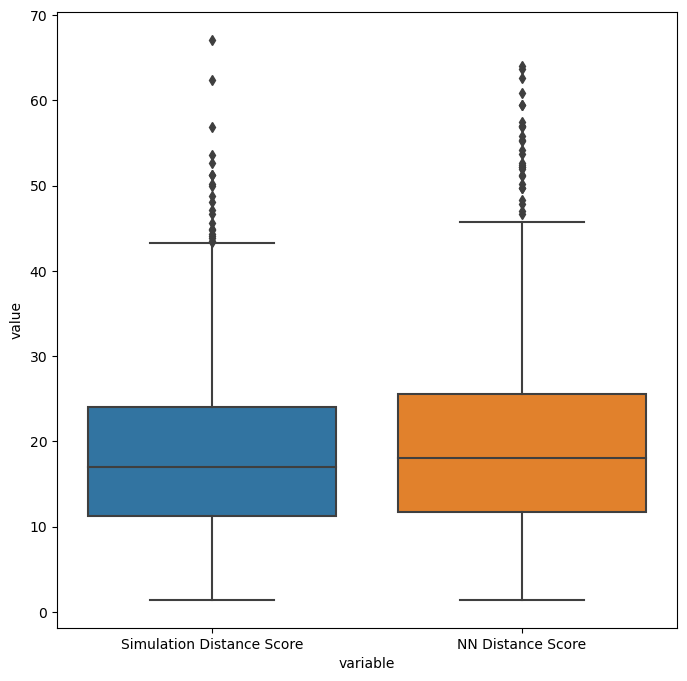

In [82]:
plot_data_1 = merged_results[['Game','Simulation Distance Score','NN Distance Score']].copy().melt(id_vars='Game')
fig, ax=plt.subplots(figsize=(8,8))
sns.boxplot(x='variable', y='value', data=plot_data_1)

<AxesSubplot:xlabel='variable', ylabel='value'>

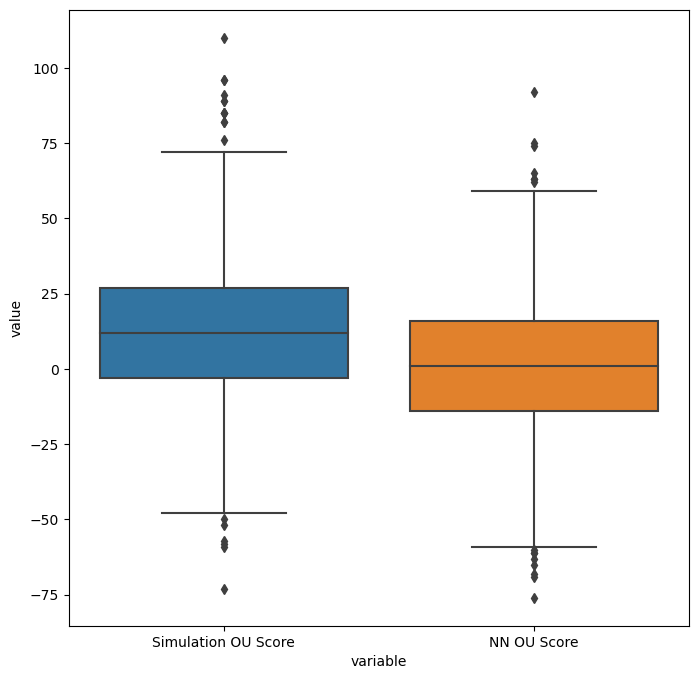

In [83]:
plot_data_2 = merged_results[['Game','Simulation OU Score','NN OU Score']].copy().melt(id_vars='Game')
fig, ax=plt.subplots(figsize=(8,8))
sns.boxplot(x='variable', y='value', data=plot_data_2)

In [ ]:
merged_results[['Game','Simulation Distance Score','NN Distance Score']].copy().melt(id_vars='Game')

In [84]:
merged_results['Simulation Winner Score'].mean()

0.5319320937752627

In [85]:
merged_results['NN Winner Score'].mean()

0.5901374292643492

In [43]:
len(predictions)

2

In [32]:
game_res

(65, 90)

In [47]:
res=np.random.choice(np.arange(1,202), 1, p=predictions[0][0])

In [48]:
res

array([66])

In [17]:
combined_matrix = combine_team_matrix(matrix1, matrix2)

In [ ]:
##### OLD CODE BELOW FOR SECOND NN ARCHITECTURE - MAY REVISIT LATER

In [92]:
res.max()

108

In [51]:
len(predictions[0][0])

201

In [43]:
real_scores = output_list[4000:]

In [44]:
accuracy_distance(predicted_scores,real_scores)

15.26440597207573

In [60]:
def build_regularized_model():
    input1 = layers.Input(shape=(18, 18))
    input2 = layers.Input(shape=(18, 18))

    flatten1 = layers.Flatten()(input1)
    flatten2 = layers.Flatten()(input2)

    concat = layers.Concatenate()([flatten1, flatten2])
    
    # Wide sparse layers with L1 regularization
    dense1 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1(0.01))(concat)
    dropout1 = layers.Dropout(0.5)(dense1)
    
    dense2 = layers.Dense(256, activation='sigmoid', kernel_regularizer=regularizers.l1(0.01))(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)

    # Wide sparse layers with L1 regularization
    dense3 = layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l1(0.01))(dropout2)
    dropout3 = layers.Dropout(0.5)(dense2)
    
    dense4 = layers.Dense(64, activation='sigmoid', kernel_regularizer=regularizers.l1(0.01))(dropout3)
    dropout4 = layers.Dropout(0.5)(dense3)

    d5=layers.Dense(102377, activation='sigmoid')(dense4)
    d6=layers.Dense(219, activation='sigmoid')(d5)
    d7=layers.Dense(23456, activation='relu')(d6)
    d8=layers.Dense(129, activation='softmax')(d7)
    d9=layers.Dense(32, activation='sigmoid')(d8)

    output1 = layers.Dense(201, activation='softmax', name='output1')(d9)  # Adjust output dimension to match the range (150 - 50 + 1)
    output2 = layers.Dense(201, activation='softmax', name='output2')(d9)  # Adjust output dimension to match the range (150 - 50 + 1)

    model = Model(inputs=[input1, input2], outputs=[output1, output2])
    return model

In [140]:
def train_model_2(matrixA_list, matrixB_list, output_tuple_list, epochs=10, batch_size=32):
    # Convert DataFrame to numpy arrays
    matrixA_array = np.array(matrixA_list)
    matrixB_array = np.array(matrixB_list)
    output_array = np.array(output_tuple_list)
    
    # Build the model
    model = build_regularized_model()

    # Compile the model
    model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

    # Train the model
    model.fit([matrixA_array, matrixB_array], [output_array[:, 0], output_array[:, 1]], epochs=epochs, batch_size=batch_size)
    return model

In [ ]:
m2 = train_model_2(matrix_A_train, matrix_B_train, y_train, 10, 64)

In [126]:
a

<tf.Tensor 'IteratorGetNext:3' shape=(None, 201) dtype=float32>

In [111]:
predicted_scores_2 = []
for i in tqdm.tqdm(range(len(matrix_A_test))[:10]):
    # Convert test matrices to numpy arrays
    test_matrix_a_array = matrix_A_test[i].values.reshape(-1, 18, 18)
    test_matrix_b_array = matrix_B_test[i].values.reshape(-1, 18, 18)

    # Make predictions using the model
    predictions = m2.predict([test_matrix_a_array, test_matrix_b_array], verbose=0)

    predicted_score = (np.argmax(predictions[0]), np.argmax(predictions[1]))

    predicted_scores_2.append(predicted_score)

100%|██████████| 10/10 [00:00<00:00, 18.60it/s]


In [112]:
predicted_scores_2

[(76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69)]